In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# 日本語フォントを設定
font = {'family': 'IPAexGothic'}
mpl.rc('font', **font)

%matplotlib inline

---
# カーネル主成分分析
## カーネル主成分分析の概要
> 非線形データをより高次元の空間に変換する非線形写像を実行し、その高次元空間に対して標準のPCAを適用し、より低次元の空間へデータを再び射影する分析手法

## カーネル主成分の導出
<img scr="./imgs/カーネル行列の導出①.png">
<img scr="./imgs/カーネル行列の導出②.png">

---
# カーネルPCAの計算手順

 1. カーネル(類似度)行列$\boldsymbol {\mathrm {K}}$を計算
 2. カーネル行列$\boldsymbol {\mathrm {K}}$を中心化
 3. 中心化されたカーネル行列$\boldsymbol {\mathrm {K}}^{\prime}$の固有値、その固有値に対応する固有ベクトルを計算。第$k$主成分まで求めるには、最大固有値から順に$k$個の固有値と固有ベクトルを取得。

---
# Pythonでカーネル主成分分析を実装

In [4]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh


def rbf_kernel_pca(X, gamma, n_components):
    """
    RBFカーネルPCAの実装

    Parameters
    ----------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      RBFカーネルのチューニングパラメータ
        
    n_components: int
      返される主成分の個数

    Returns
    -------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       射影されたデータセット
    """
    sq_dists = pdist(X, 'sqeuclidean')   # M×N次元のデータセットでペアごとのユークリッド距離の２乗を計算.
    mat_sq_dists = squareform(sq_dists)  # ペアごとの距離を正方行列に変換.

    # 対称カーネル行列を計算.
    K = exp(-gamma * mat_sq_dists)

    # カーネル行列を中心化.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 中心化されたカーネル行列から固有対を取得.
    # scipy.linalg.eigh はそれらを昇順で返す.
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 上位k個の固有ベクトル(射影されたサンプル)を取得
    X_pc = np.column_stack( (eigvecs[:, i] for i in range(n_components)) )

    return X_pc

**備考**<br>
> RBFカーネルPCAを次元圧縮として利用する際は、[Grid Search](https://qh73xebitbucketorg.readthedocs.io/ja/latest/1.Programmings/python/LIB/scikit-learn/girdSearch/)等でハイパラメータをチューニングする

## 例1) 半月形の分離

In [13]:
from sklearn.datasets import make_moons


X,y = make_moons(n_samples=100, random_state=123)

In [16]:
print(X[:10])
print(y)

[[ 0.8713187   0.49071755]
 [ 0.71547241 -0.45866785]
 [ 1.46253829 -0.38659931]
 [-0.22252093  0.97492791]
 [ 0.32769911 -0.240278  ]
 [ 1.          0.        ]
 [ 0.94905575  0.31510822]
 [ 0.          0.5       ]
 [ 1.40478334 -0.41441262]
 [ 0.96729486  0.25365458]]
[0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1
 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1
 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1]


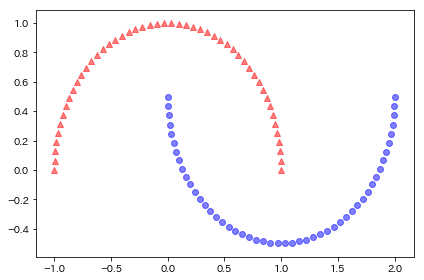

In [18]:
# 負例、正例
neg_label = 0
pos_label = 1

plt.scatter(X[y==neg_label, 0], X[y==neg_label,1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==pos_label, 0], X[y==pos_label,1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

### 主成分分析(PCA)による次元圧縮

In [20]:
from sklearn.decomposition import PCA

DIM = 2

# 主成分分析
scikit_pca = PCA(n_components=DIM) # 第2主成分まで求める。
X_spca = scikit_pca.fit_transform(X)

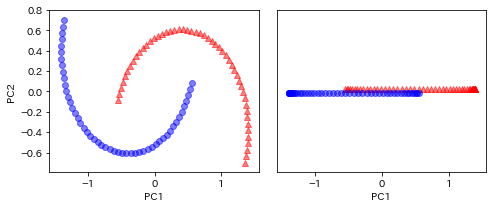

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

# 第1,2主成分で描写
ax[0].scatter(X_spca[y == neg_label, 0], X_spca[y == neg_label, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == pos_label, 0], X_spca[y == pos_label, 1], color='blue', marker='o', alpha=0.5)

# 第1主成分だけの描写(重なりがわかりやすくなるように少しだけ上下にずらしている)
ax[1].scatter(X_spca[y == neg_label, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == pos_label, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_13.png', dpi=300)
plt.show()

In [24]:
print('各次元の寄与率: {0}'.format(scikit_pca.explained_variance_ratio_))
print('累積寄与率    : {0}'.format(sum(scikit_pca.explained_variance_ratio_)))

各次元の寄与率: [0.81968748 0.18031252]
累積寄与率    : 1.0


In [30]:
pd.DataFrame(X).corr()

,0,1
0,1.000000,-0.436869
1,-0.436869,1.000000


(疑問点？：線形分離を行いたいのが目的なら上記の結果では十分な性能を出せないが、”次元圧縮”が目的ならPCAによる第1主成分だけで82%説明できているので十分？？？そもそも線形分離したいのなら、より高次元へ射影したほうが良いのでは。。。？線形分離がしたいのか次元圧縮がしたいのかよくわからないです。わかる方、助けてくださいm(><;)m )

### カーネルPCA(RBF)による次元圧縮

In [26]:
DIM   = 2
GAMMA = 15
X_kpca = rbf_kernel_pca(X, gamma=GAMMA, n_components=DIM)

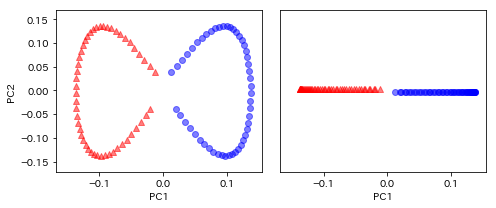

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))


ax[0].scatter(X_kpca[y==neg_label, 0], X_kpca[y==neg_label, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==pos_label, 0], X_kpca[y==pos_label, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==neg_label, 0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==pos_label, 0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_14.png', dpi=300)
plt.show()

うまく線形分離できるようなデータセットになった

## 例2) 同心円の分離

In [33]:

from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
print(X[:10])
print(y[:10])

[[-0.08769568  1.08597835]
 [-0.83755821  0.54731034]
 [ 0.79684284  0.41149548]
 [ 0.21215762  0.10698486]
 [-0.0536839   0.9796336 ]
 [ 0.0892458   0.23355252]
 [-0.56754307 -0.80796973]
 [ 0.73499347 -0.470101  ]
 [ 0.28711857 -0.03244849]
 [ 0.86687928 -0.21027292]]
[0 0 0 1 0 1 0 0 1 0]


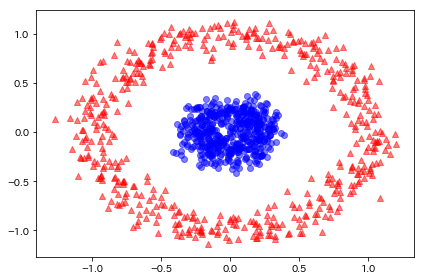

In [32]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_15.png', dpi=300)
plt.show()

### PCAによる次元圧縮

In [36]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

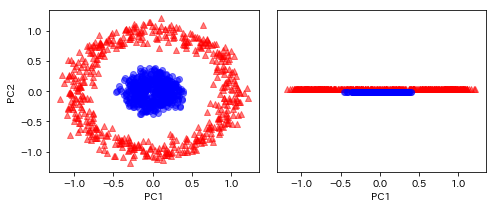

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_16.png', dpi=300)
plt.show()

### カーネルPCA(RBF)による次元圧縮

In [37]:
GAMMA  = 15
X_kpca = rbf_kernel_pca(X, gamma=GAMMA, n_components=2)

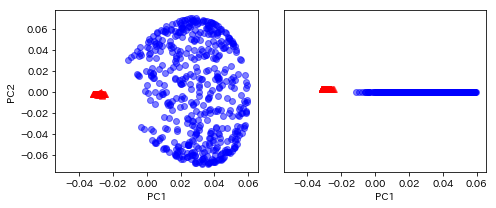

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_17.png', dpi=300)
plt.show()

---
# 新しいデータ$\boldsymbol {x}^{\prime}$を射影する
$$
Kernel PCA\left( \boldsymbol {x}^{\prime} \right) = \sum _{i=1}^{n}{ \boldsymbol {\alpha}_{i} k\left( \boldsymbol {x}^{\prime}, \boldsymbol {x}_{i} \right) }
$$

 - $n$ : トレーニングデータセットのサンプル数
 - $\boldsymbol {\alpha}_{i}$ : 中心化されたカーネル行列の固有ベクトル
 - $k\left( \boldsymbol {x}^{\prime}, \boldsymbol {x}_{i} \right)$ : カーネル関数

データ数が少ない場合に適用することが多い

In [40]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBFカーネルPCAの実装

    Parameters
    ----------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      RBFカーネルのハイパーパラメータ
        
    n_components: int
      返される主成分の個数

    Returns
    -------
     alphas: {NumPy ndarray}, shape = [n_samples, k_features]
       射影されたデータセット
     
     lambdas: list
       固有値

    """
    sq_dists = pdist(X, 'sqeuclidean')   # ユークリッド距離を計算
    mat_sq_dists = squareform(sq_dists)  # ペアごとの距離を正方行列に変換

    K = exp(-gamma * mat_sq_dists)       # 対称カーネル行列を計算

    # カーネル行列を中心化
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 中心化されたカーネル行列から固有対を取得
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 上位k個の固有ベクトル(射影されたサンプルを収集)
    alphas = np.column_stack( (eigvecs[:, i] for i in range(n_components)) )

    # 対応する固有値を収集
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

## 例3) 半月形データセット

In [41]:
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=100, random_state=123)
print(X[:10])
print(y[:10])

[[ 0.8713187   0.49071755]
 [ 0.71547241 -0.45866785]
 [ 1.46253829 -0.38659931]
 [-0.22252093  0.97492791]
 [ 0.32769911 -0.240278  ]
 [ 1.          0.        ]
 [ 0.94905575  0.31510822]
 [ 0.          0.5       ]
 [ 1.40478334 -0.41441262]
 [ 0.96729486  0.25365458]]
[0 1 1 0 1 0 0 1 1 0]


In [42]:
# 射影されたデータセット, 固有値
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [52]:
# 射影前のデータ(2次元)
x_new = X[25]
x_new

array([1.8713187 , 0.00928245])

In [51]:
# 1次元空間に射影済みのデータ
x_proj = alphas[25] # original projection
x_proj

array([0.07877284])

In [53]:
def project_x(x_new, X, gamma, alphas, lambdas):
    """
    Parameters
    ----------
    alphas: {NumPy ndarray}, shape = [n_samples, k_features]
       射影されたデータセット
     
     lambdas: list
       固有値
    """
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    # RBF関数を計算
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([0.07877284])

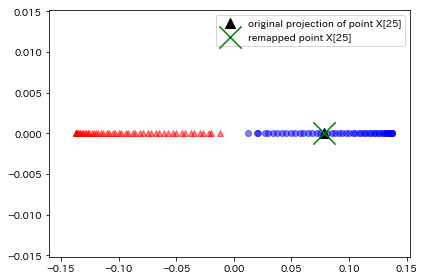

In [55]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)

# 射影済みのデータ
plt.scatter(x_proj, 0, color='black', label='original projection of point X[25]', marker='^', s=100)
# `project_x`を適用したデータ
plt.scatter(x_reproj, 0, color='green', label='remapped point X[25]', marker='x', s=500)

plt.legend(scatterpoints=1)
plt.tight_layout()
# plt.savefig('images/05_18.png', dpi=300)
plt.show()

---
# scikit-learnのカーネル主成分分析

参考サイト

 - [sklearn.decomposition.KernelPCA — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)

In [57]:
N = 100
X, y = make_moons(n_samples=N, random_state=123)

In [84]:
from sklearn.decomposition import KernelPCA


DIM    = 2
KERNEL = 'rbf'
GAMMA  = 15

# カーネルPCAクラスのインスタンスを生成
scikit_kpca = KernelPCA(n_components=DIM, kernel=KERNEL, gamma=GAMMA)
X_skernpca = scikit_kpca.fit_transform(X)

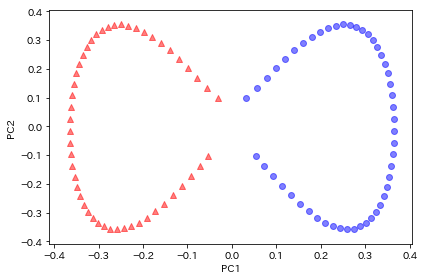

In [85]:
plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('images/05_19.png', dpi=300)
plt.show()

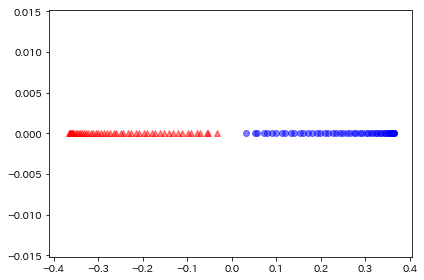

In [87]:
plt.scatter(X_skernpca[y == 0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

## 新たなデータ$\boldsymbol {x}^{\prime}$を射影する

In [90]:
print(X[25])
print(X_skernpca[25])

[1.8713187  0.00928245]
[ 0.20934501 -0.33483988]


In [95]:
scikit_kpca.transform(np.array([X[25]]))

array([[ 0.20934501, -0.33483988]])

---
# 参考文献

書籍
 - Sebastian Raschka, Vahid Mirjalili[2018]「5.3 カーネル主成分分析を使った非線形写像」『［第2版］Python機械学習プログラミング達人データサイエンティストによる理論と実践』株式会社インプレス（162~180頁）

Webサイト

 - [カーネル法による非線形データ解析入門 - 統計数理研究所](http://www.ism.ac.jp/~fukumizu/papers/Kernel_rois2006.pdf)
 - [python-machine-learning-book-2nd-edition/ch05.ipynb at master · rasbt/python-machine-learning-book-2nd-edition](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch05/ch05.ipynb)